In [6]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp
from time import time

from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

from scipy.stats import norm
from scipy.stats.mstats import gmean

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
agg_data = pd.read_csv('../data/agg_growth.csv', index_col=0)
agg_data.head()

,Drug,Concentration,Target,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,...,uacc812,uacc893,umc11,umuc3,vmrclcd,wm115,wm2664,yapc,zr751,zr75b
53257,silmitasertib,3.00,-0.426184,-0.330026,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
42989,osi027,0.03,2.489425,0.987205,0.0,0.000000,0.000000,0.0,0.076540,0.0,...,0,0,0,0,0,0,0,0,0,0
36715,mgcd265,0.30,3.085930,0.997971,0.0,-0.367669,-0.212716,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
35826,masitinib,1.00,0.895365,0.629408,0.0,-0.478263,-0.317027,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
43312,osi027,30.00,-0.056795,-0.045292,0.0,0.000000,0.000000,0.0,-9.642757,0.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
conc = agg_data.Concentration
drugs = agg_data.Drug
# targ = agg_data.Target # deprecated
y = agg_data.Growth
new_y = np.arctanh(y) # throws a warning as inf occurs
new_y[y == 1] = np.arctanh(1 - 1e-12) # replace inf with large number

X = agg_data[agg_data.columns[4:]]

print(X.shape)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in arctanh
  """
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arctanh
  """


(62368, 662)


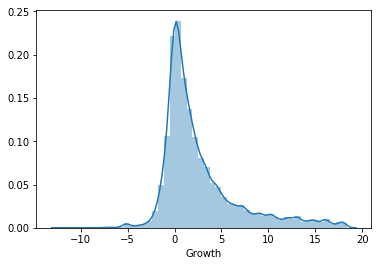

In [8]:
sns.distplot(new_y)
plt.show()
#plt.h

In [12]:
# set parameters
cv_jobs = 12
n_jobs = 1

# 4 layer MLP regressor
hidden_layer_sizes = (100, 100) # n_layers - 2
activation = 'relu'
alphas = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
batch_size = 32
learning_rate = 'invscaling'
random_state = 1920
nesterovs_momentum = True

model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                     activation=activation,
                     batch_size=batch_size,
                     learning_rate=learning_rate,
                     random_state=random_state,
                     nesterovs_momentum=nesterovs_momentum)

In [13]:
# cross validator
logo = LeaveOneGroupOut()

# we can't grid search across threshes, so store a dict of them
thresh_grids = {}
param_grid = {
    'alpha' : alphas,
}

scorer_dict = {'mse':mean_squared_error,
              'pearsonr':lambda x,y: pearsonr(x,y)[0]}

# convert to scorers
scorer_dict = {x:make_scorer(y) for x,y in scorer_dict.items()}

In [14]:
# define the threshes
search = GridSearchCV(model,
                     cv=logo.split(X, y, groups=drugs),
                     param_grid=param_grid,
                     pre_dispatch='2*n_jobs',
                     n_jobs=cv_jobs,
                     iid=False,
                     refit=False,
                     return_train_score=True)

In [30]:
for thresh, gCV in thresh_grids.items():
    gCV.fit(X, new_y)

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left

In [ ]:
for thresh, gCV in thresh_grids.items():
    dat = pd.DataFrame(gCV.cv_results_)
    dat.to_csv('~/Github/subnetGRcurves/results/gCV_' + str(thresh) + '.csv')

In [136]:
res = pd.DataFrame(pd.Series(val_scores))
res = pd.concat([res.drop(0, axis=1).reset_index(), pd.DataFrame(list(zip(*res[0]))).T], axis=1)
res.columns = ['Loss', 'Weights', 'L1_Ratio', 'Alpha', 'Thresh', 'AP_score', 'ROC_AUC', 'Accuracy', 'F1_score', 'R2']
res.to_csv('../results/validation_scores.csv', index=False)

### Test Set Analysis

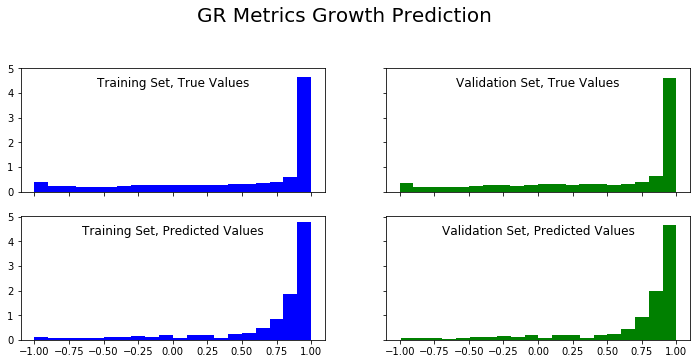

In [404]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

axes[0][0].hist(y['train'], bins=20, density=True, color='b')
axes[0][0].set_title('Training Set, True Values', y=.8)

axes[0][1].hist(y['dev'], bins=20, density=True, color='g')
axes[0][1].set_title('Validation Set, True Values', y=.8)

axes[1][0].hist((norm.cdf(p_train)-.5)*2, bins=20, density=True, color='b')
axes[1][0].set_title('Training Set, Predicted Values', y=.8)

axes[1][1].hist((norm.cdf(p_dev)-.5)*2, bins=20, density=True, color='g')
axes[1][1].set_title('Validation Set, Predicted Values', y=.8)

plt.show()